In [124]:
import pandas as pd
import numpy as np
from datetime import datetime
import csv

from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.pyplot as plt
import matplotlib.dates as mpl_dates

In [125]:
stock = pd.read_csv(r'D:\quant\index_futures\HS300\HS300.csv')
stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2434 entries, 0 to 2433
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2434 non-null   object 
 1   Open    2434 non-null   float64
 2   Close   2434 non-null   float64
 3   High    2434 non-null   float64
 4   Low     2434 non-null   float64
 5   volume  2434 non-null   int64  
 6   money   2434 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 133.2+ KB


In [126]:
date = stock["Date"]
open_price = stock["Open"]
close_price = stock["Close"]
high_price =stock["High"]
low_price = stock["Low"]

In [128]:
mid_channel = close_price.rolling(window = 10).mean()
std = close_price.rolling(window = 10).std()
high_channel = mid_channel + 2 * std
low_channel = mid_channel - 2 * std

C:\Users\bangy\AppData\Local\Temp\ipykernel_11448\2432657369.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ohlc.loc[:,'Date'] = range(len(ohlc))


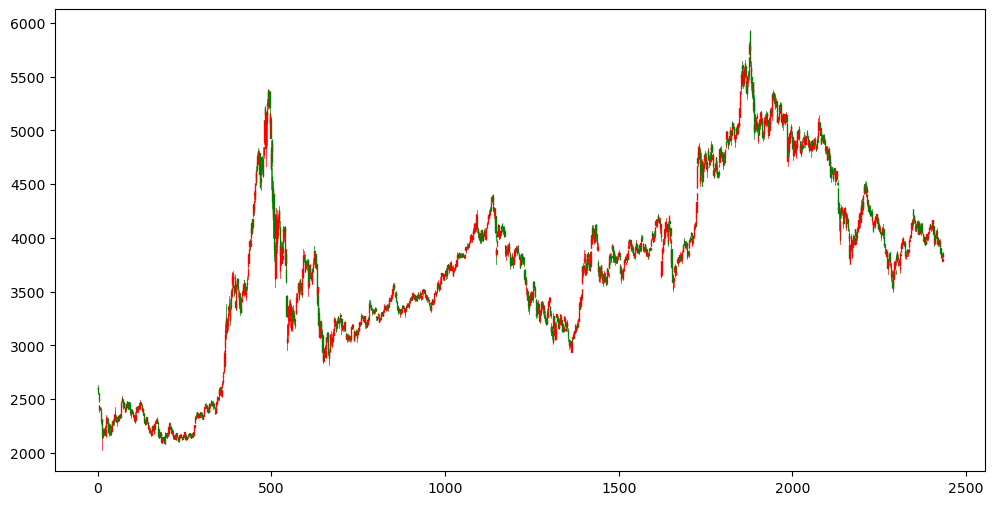

In [129]:
ohlc = stock[['Date', 'Open', 'High', 'Low', 'Close']]
ohlc.loc[:,'Date'] = range(len(ohlc))
f1, ax = plt.subplots(figsize = (12,6))

candlestick_ohlc(ax, ohlc.values.tolist(), width=.7, colorup='red', colordown='green') 

plt.show()

In [130]:
ma_option = [3, 5, 10, 20, 26, 60]
std_option = [0.5, 1, 1.5, 2, 2.5, 3]

total_return = [[0 for _ in range(6)] for _ in range(6)]
total_dawndown = [[0 for _ in range(6)] for _ in range(6)]
total_profit_ratio = [[0 for _ in range(6)] for _ in range(6)]
total_win_rate = [[0 for _ in range(6)] for _ in range(6)]
total_transaction = [[0 for _ in range(6)] for _ in range(6)]


In [132]:
open_long = True
open_short = True

for ma_num in range(len(ma_option)):
    for std_num in range(len(std_option)):

        mid_channel = close_price.rolling(window = ma_option[ma_num]).mean()
        std = close_price.rolling(window = ma_option[ma_num]).std()
        high_channel = mid_channel + std_option[std_num] * std
        low_channel = mid_channel - std_option[std_num] * std

        total_money = open_price[0]
        current_money = [total_money for _ in range(4)]
        cush = total_money

        total_long_unit = 0
        total_short_unit = 0

        long_entry_price = []
        long_quit_price = []
        short_entry_price = []
        short_quit_price = []

        long_open_position_day = []
        short_open_position_day = []
        long_close_position_day = []
        short_close_position_day = []
        
        for days in range(4, len(open_price)):
            
            long_operation = False
            short_operation = False
            
            if total_long_unit > 0 and open_price[days] < mid_channel[days-1]:
                cush = cush + open_price[days] * 0.9999
                long_quit_price.append(open_price[days])
                total_long_unit = 0
                long_operation = True
                long_close_position_day.append(days)
            
            if total_short_unit > 0 and open_price[days] > mid_channel[days-1]:
                cush = cush - open_price[days] * 1.0001
                short_quit_price.append(open_price[days])
                total_short_unit = 0
                short_operation = True
                short_close_position_day.append(days)

            
            if total_long_unit > 0 and low_price[days] < mid_channel[days-1]:
                cush = cush + mid_channel[days-1] * 0.9999
                long_quit_price.append(mid_channel[days-1])
                total_long_unit = 0
                long_operation = True
                long_close_position_day.append(days)
            
            if total_short_unit > 0 and high_price[days] > mid_channel[days-1]:
                cush = cush - mid_channel[days-1] * 1.0001
                short_quit_price.append(mid_channel[days-1])
                total_short_unit = 0
                short_operation = True
                short_close_position_day.append(days)
            
                

            if open_long == True:
                if high_price[days] >= high_channel[days-1] and low_price[days] <= high_channel[days-1] and total_long_unit == 0 and long_operation == False:
                    cush = cush - high_channel[days-1] * 1.0001
                    total_long_unit = 1
                    long_entry_price.append(high_channel[days-1])
                    long_open_position_day.append(days)
            
            if open_short == True:
                if high_price[days] >= low_channel[days-1] and low_price[days] <= low_channel[days-1] and total_short_unit == 0 and short_operation == False:
                    cush = cush + low_channel[days-1] * 0.9999
                    total_short_unit = 1
                    short_entry_price.append(low_channel[days-1])
                    short_open_position_day.append(days)
            

            if days == len(open_price) - 1 and total_long_unit > 0:
                total_long_unit = 0
                cush = cush + close_price[days] * 0.9999
                long_close_position_day.append(len(open_price)-1)
                long_quit_price.append(close_price[len(close_price)-1])
            
            if days == len(open_price) - 1 and total_short_unit > 0:
                total_short_unit = 0
                cush = cush - close_price[days] * 1.0001
                short_close_position_day.append(len(open_price)-1)
                short_quit_price.append(close_price[len(close_price)-1])
            
                
            if total_long_unit > total_short_unit:
                current_money.append(cush + close_price[days] * 0.9999)
            else:
                current_money.append(cush - (total_short_unit - total_long_unit) * close_price[days] * 1.0001)
        
        maxcum = np.zeros(len(current_money))
        b = current_money[0]
        for i in range(0,len((current_money))):
            if (current_money[i] > b):
                b = current_money[i]
            maxcum[i] = b
        i = np.argmax((maxcum-current_money) / maxcum) 
        j = np.argmax(current_money[:i])   

        max_dawndown = (current_money[j] - current_money[i]) / current_money[j]
        
        win_times = 0
        win_money = 0
        lose_time = 0
        lose_money = 0
        
        for i in range(len(long_open_position_day)):
            if long_quit_price[i] * 0.9999 - long_entry_price[i] * 1.0001 >= 0:
                win_times = win_times + 1
                win_money = win_money + (long_quit_price[i] * 0.9999 - long_entry_price[i] * 1.0001)
            else:
                lose_time = lose_time + 1
                lose_money = lose_money - (long_quit_price[i] * 0.9999 - long_entry_price[i] * 1.0001)
        for i in range(len(short_open_position_day)):
            if short_entry_price[i] * 0.9999 - short_quit_price[i]* 1.0001 >= 0:
                win_times = win_times + 1
                win_money = win_money + (short_entry_price[i] * 0.9999 - short_quit_price[i]* 1.0001)
            else:
                lose_time = lose_time + 1
                lose_money = lose_money - (short_entry_price[i] * 0.9999 - short_quit_price[i]* 1.0001)

        total_return[ma_num][std_num] = str(np.round(100 * ((current_money[len(current_money)-1] / total_money) - 1), 2)) + '%'
        total_dawndown[ma_num][std_num] = str(np.round(100 * max_dawndown, 2)) + '%'
        total_profit_ratio[ma_num][std_num] = np.round(win_money / lose_money, 2)
        total_win_rate[ma_num][std_num] = str(np.round(100 * win_times / (win_times + lose_time), 2)) + '%'
        total_transaction[ma_num][std_num] = len(long_open_position_day) + len(short_open_position_day)
        
with open(r'C:\Users\bangy\Desktop\data.csv', 'a', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(total_return)
    writer.writerows(total_dawndown)
    writer.writerows(total_profit_ratio)
    writer.writerows(total_win_rate)
    writer.writerows(total_transaction)


In [ ]:
max_dawndown = 0
top_point = 0
bot_point = 0

for i in range(len(current_money)):
    for j in range(i+1, len(current_money)):
        if current_money[i] > current_money[j] and current_money[i] != 0:
            if max_dawndown < (current_money[i] - current_money[j]) / current_money[i]:
                top_point = i
                bot_point = j
                max_dawndown = max(max_dawndown, (current_money[i] - current_money[j]) / current_money[i])

def MaxDrawdown(return_list):
    
    maxcum = np.zeros(len(return_list))
    b = return_list[0]
    for i in range(0,len((return_list))):
        if (return_list[i]>b):
            b = return_list[i]
        maxcum[i] = b
    
    i = np.argmax((maxcum-return_list)/maxcum) 
    if i == 0:
        return 0
    j = np.argmax(return_list[:i])   

    return (return_list[j]-return_list[i])/return_list[j]


print(MaxDrawdown(current_money))
print(max_dawndown)
print(top_point, bot_point)
print(current_money[top_point] - current_money[bot_point])

In [ ]:
print(current_money[len(current_money)-1])
print((current_money[len(current_money)-1] / total_money) - 1)
plt.plot(current_money)
plt.show()

In [ ]:
print(len(long_open_position_day) + len(short_open_position_day))

In [ ]:
win_times = 0
win_money = 0
lose_time = 0
lose_money = 0

for i in range(len(long_open_position_day)):
    if long_quit_price[i] * 0.9999 - long_entry_price[i] * 1.0001 >= 0:
        win_times = win_times + 1
        win_money = win_money + (long_quit_price[i] * 0.9999 - long_entry_price[i] * 1.0001)
    else:
        lose_time = lose_time + 1
        lose_money = lose_money - (long_quit_price[i] * 0.9999 - long_entry_price[i] * 1.0001)

for i in range(len(short_open_position_day)):
    if short_entry_price[i] * 0.9999 - short_quit_price[i]* 1.0001 >= 0:
        win_times = win_times + 1
        win_money = win_money + (short_entry_price[i] * 0.9999 - short_quit_price[i]* 1.0001)
    else:
        lose_time = lose_time + 1
        lose_money = lose_money - (short_entry_price[i] * 0.9999 - short_quit_price[i]* 1.0001)

print("profit-loss ratio: ", win_money / lose_money)
print("winning percentage: ", win_times / (win_times + lose_time))

In [ ]:
print("Origin: Rate of return:", (close_price[len(close_price)-1]/ open_price[0] - 1))